# MobileNet v3 large 100 사용

In [1]:
import os
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5" # 모델 url
# tensor hub -> https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5

IMAGE_SHAPE = (224, 224)

layer = hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,))
model = tf.keras.Sequential([layer])
model.summary()

Metal device set to: Apple M1 Pro


2022-09-05 14:22:15.676331: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-05 14:22:15.676482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
Total params: 4,226,432
Trainable params: 0
Non-trainable params: 4,226,432
_________________________________________________________________


In [6]:
model.build([None, 224, 224, 3])

In [26]:
def extract(file):
    file = Image.open(file).resize(IMAGE_SHAPE)
    # plt.imshow(file)

    file = np.array(file)/255.0 # 정규화

    embedding = model.predict(file[np.newaxis, ...])
    mobilenet_np = np.array(embedding)
    flattended_feature = mobilenet_np.flatten()

    return flattended_feature

In [27]:
extract('cap_marant.jpg')

1/1 [==============================] - 0s 20ms/step


array([-0.37408793, -0.3446977 ,  0.15052474, ..., -0.30704185,
        0.20344159, -0.316452  ], dtype=float32)

In [28]:
def make_dataframe(category):
    path = f"../crops/{category}/"
    file_list = os.listdir(path)
    file_list_img = [file for file in file_list if file.endswith(".png") or file.endswith(".jpeg") or file.endswith(".jpg")]
    tmp_df = pd.DataFrame()
    for i, img in enumerate(tqdm(file_list_img)):
        output = extract(path+'/'+img)
        tmp_df = tmp_df.append({'filename':img, 'output':output}, ignore_index=True)

    np.save(path+f'{category}_filename(MobileNet).npy', tmp_df['filename'])
    np.save(path+f'{category}_output(MobileNet).npy', tmp_df['output']) # np.array배열 형태로 나중에 불러오기 위해 따로 저장

In [29]:
make_dataframe('cap')

  0%|          | 0/3429 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


In [30]:
def get_dataframe(category):
    path = f"../crops/{category}/"
    tmp_filename = np.load(path+f'{category}_filename(MobileNet).npy', allow_pickle=True)
    tmp_output = np.load(path+f'{category}_output(MobileNet).npy', allow_pickle=True)
    df = pd.DataFrame({'filename':tmp_filename, 'output':tmp_output})
    return df

In [31]:
from scipy.spatial import distance
def get_cos_sim(file, category, metric='cosine'):
    before_time = time.time()
    file2vec = extract(file) # 이미지 벡터화
    df = get_dataframe(category) # 데이터프레임 가져오기
    df = df.append({'filename':file, 'output':file2vec}, ignore_index=True)
    
    cos_sim_array = np.zeros((len(df)))
    for i in range(0, len(df)):
        cos_sim_array[i] = distance.cdist([file2vec] , [df.iloc[i, 1]], metric)[0] # 벡터화된 이미지 기준
    df['cos_sim']=cos_sim_array
    after_time = time.time()
    runtime = after_time-before_time
    return df, runtime

In [46]:
def show_sim(filename, category):
    path = f"../crops/{category}/"
    cos_sim_df, runtime = get_cos_sim(filename, category)
    df_top_sim = cos_sim_df.sort_values(by='cos_sim')[:15]
    # 그래프 그리는 부분은 서비스 시 생략 가능
    f, ax = plt.subplots(3, 5, figsize=(40, 20))

    for i in range(len(df_top_sim)):
        if i == 0: 
            tmp_img = Image.open(df_top_sim.iloc[i, 0]).convert('RGB')
            title = f'Original \n{df_top_sim.iloc[i, 0]}'
        else : 
            tmp_img = Image.open(path+'/'+df_top_sim.iloc[i, 0]).convert('RGB')
            title = f'similarity no.{i} \n{df_top_sim.iloc[i, 0]}'

        sim = f'cos : {df_top_sim.iloc[i, 2]:.3f}' 
        ax[i//5][i%5].imshow(tmp_img, aspect='auto')
        ax[i//5][i%5].set_title(title, pad=20, size=25) # 5열짜리 표를 만드는 것이므로 단순히 5로 나눈 나머지와 몫을 사용한 것임
        ax[i//5][i%5].annotate(sim, (0,10), fontsize=18, color='red')

    
    print(f'소요시간 : {runtime:.3f}')
    plt.show()

1/1 [==============================] - 0s 25ms/step
소요시간 : 0.154


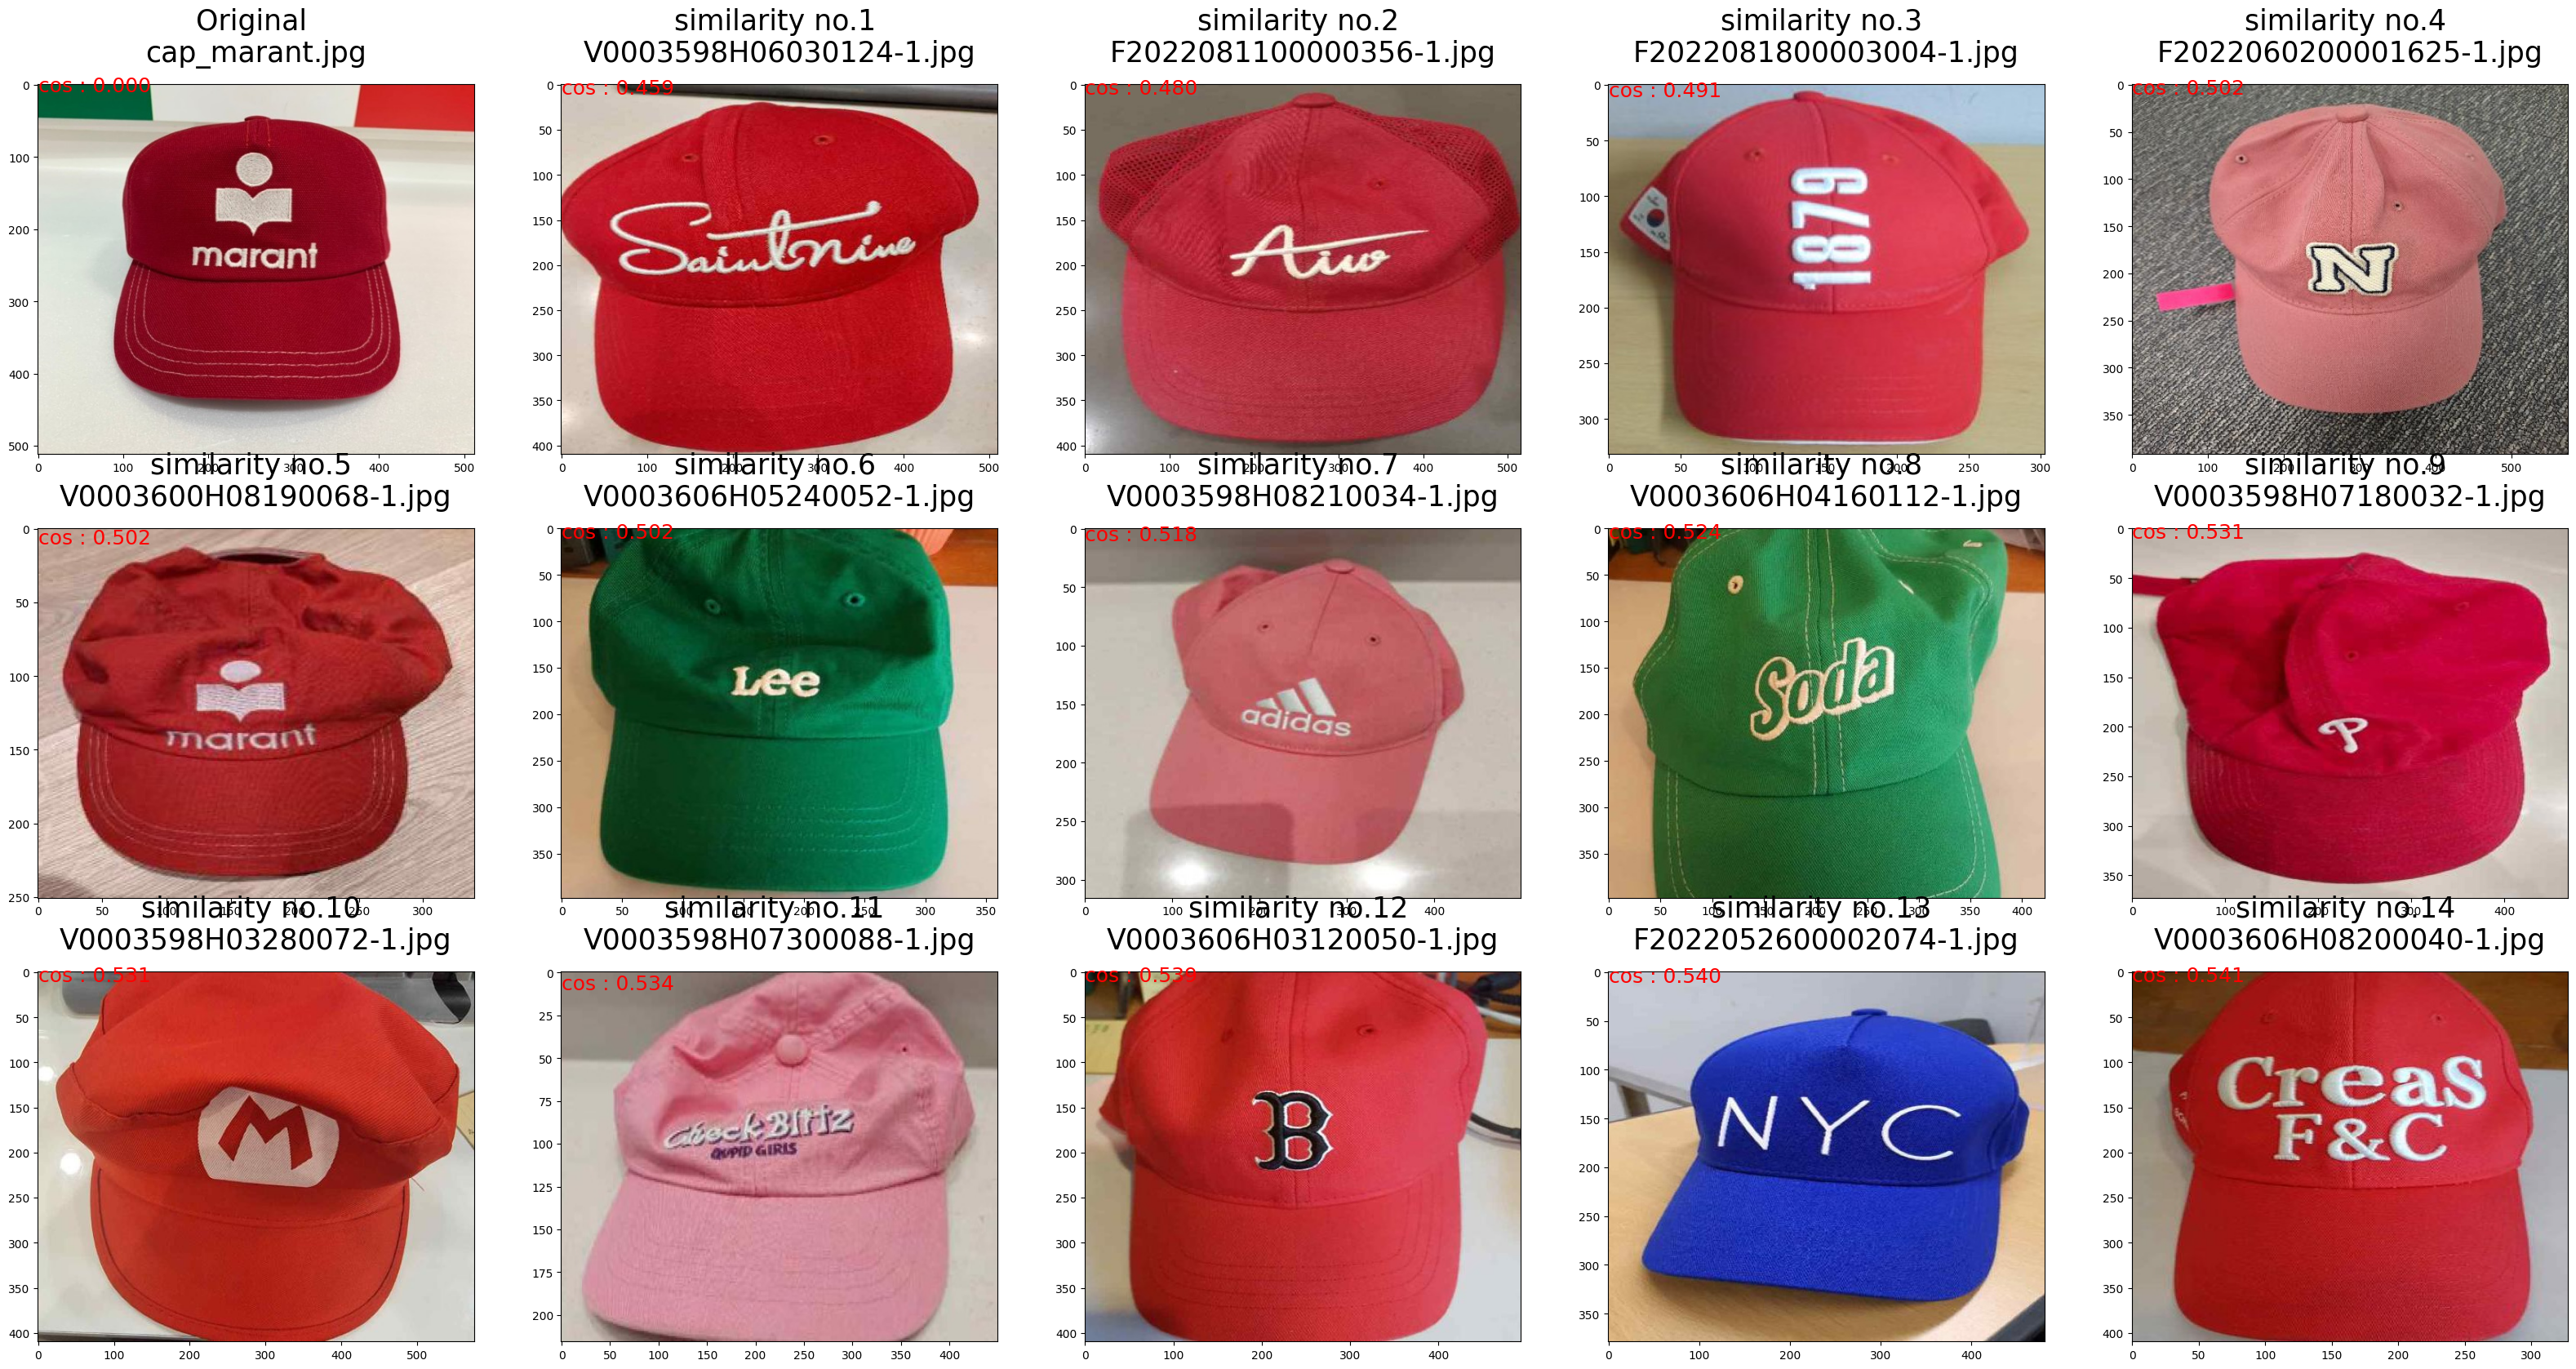

In [45]:
show_sim('cap_marant.jpg', 'cap')

In [43]:
def get_runtime():
    runtime_list = list()
    for i in range(100):
        df, runtime = get_cos_sim('cap_marant.jpg', 'cap')
        runtime_list.append(runtime)
    runtime_mean = np.mean(runtime_list)
    print(f'100회 평균 소요시간 : {runtime_mean:.3f}')

get_runtime()

1/1 [==============================] - 0s 16ms/step
100회 평균 소요시간 : 0.110
